In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib


Selecting previously unselected package libta-lib0.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 269 kB 4.3 MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.24-cp37-cp37m-linux_x86_64.whl size=1465762 sha256=2602478db73629492eff2dcc656a61b75b6796a96b33e012547b8e6acba1c18f
  Stored in directory: /root/.cache/pip/wheels/02/b1/a5/aca31e8cdd0137d7a83bf72237056b8705663dd1f9b5eac11e
Successfully built ta-lib


In [2]:
!pip install freqtrade


     |████████████████████████████████| 584 kB 3.9 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 40.9 MB/s 
     |████████████████████████████████| 51 kB 476 kB/s 
     |████████████████████████████████| 115 kB 40.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 497 kB 39.2 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 2.5 MB 37.5 MB/s 
     |████████████████████████████████| 2.6 MB 27.8 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 
     |████████████████████████████████| 1.1 MB 33.8 MB/s 
  Using cached setuptools-61.1.1-py3-none-any.whl (1.1 MB)
     |████████████████████████████████| 3.6 MB 30.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████

In [8]:
import json, os
from pathlib import Path

from freqtrade.configuration import Configuration
from freqtrade.data.btanalysis import load_trades_from_db, load_backtest_data, load_backtest_stats
from freqtrade.data.history import load_pair_history
from freqtrade.data.dataprovider import DataProvider
from freqtrade.plugins.pairlistmanager import PairListManager
from freqtrade.exceptions import ExchangeError, OperationalException
from freqtrade.exchange import Exchange
from freqtrade.resolvers import ExchangeResolver, StrategyResolver
from freqtrade.enums import RunMode

import numpy as np
import pandas as pd
import random
from collections import deque

import nest_asyncio
nest_asyncio.apply()

configs=["cryptofrog.config.json"]

ft_config = Configuration.from_files(files=configs)
ft_exchange = ExchangeResolver.load_exchange(ft_config['exchange']['name'], config=ft_config, validate=True)
ft_pairlists = PairListManager(ft_exchange, ft_config)
ft_dataprovider = DataProvider(ft_config, ft_exchange, ft_pairlists)

data_location = Path(ft_config['user_data_dir'], 'data', 'binance')
backtest_dir = Path(ft_config['user_data_dir'], 'backtest_results')

# Load strategy using values set above
strategy = StrategyResolver.load_strategy(ft_config)
strategy.dp = ft_dataprovider

# Generate buy/sell signals using strategy
timeframe = "1h"

backtest = False

if ft_config["timeframe"] is not None:
    timeframe = ft_config["timeframe"]
    print("Using config timeframe:" , timeframe)
elif strategy.timeframe is not None:
    timeframe = strategy.timeframe
    print("Using strategy timeframe:" , timeframe)
else:
    print("Using default timeframe:" , timeframe)

def do_analysis(pair, strategy, timeframe, only_backtest=False, hist_and_backtest=True):
    if only_backtest is True:
        print("Loading backtest data...")
        trades = load_backtest_data(backtest_dir)
    else:
        print("Loading historic data...")
        candles = load_pair_history(datadir=data_location,
                                    timeframe=timeframe,
                                    pair=pair,
                                    data_format = "json",
                                    )

        # Confirm success
        print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
        df = strategy.analyze_ticker(candles, {'pair': pair})
        
        if hist_and_backtest is True:
            print("Loading backtest trades data...")
            trades = load_backtest_data(backtest_dir)            
        else:
            # Fetch trades from database
            print("Loading DB trades data...")
            trades = load_trades_from_db(ft_config['db_url'])

        print(f"Generated {df['buy'].sum()} buy / {df['sell'].sum()} sell signals")
        data = df.set_index('date', drop=False)
        # print(data.info())
        # print(data.tail())
        # print(data["buy"].dropna())
        return (data, trades)
    
    return (pd.Dataframe(), trades)

def do_plot(pair, data, trades, plot_config=None):
    from freqtrade.plot.plotting import generate_candlestick_graph
    import plotly.offline as pyo

    # Filter trades to one pair
    trades_red = trades.loc[trades['pair'] == pair].copy()

    # Limit graph period to your BT timerange
    #data_red = data.['2021-04-01':'2022-01-01']
    idx = pd.IndexSlice
    data_red = data.loc[idx["2020-11-01":"2022-03-11"]]

    plotconf = strategy.plot_config
    if plot_config is not None:
        plotconf = plot_config
    
    # Generate candlestick graph
    graph = generate_candlestick_graph(pair=pair,
                                       data=data_red,
                                       trades=trades_red,
                                       plot_config=plotconf
                                       )

    pyo.iplot(graph, show_link = False)

Using config timeframe: 1d


# Strategy 1

In [22]:
# example inline plot config to override strat
plot_config = {
    'main_plot': {
    },
    'subplots': {
        'STR' :{
            'mastreak': {'color': 'black'},
        },
        "MACD": {
                'macd': {'color': 'blue'},
                'macdsignal': {'color': 'orange'},
            },
        'RSI' :{
            'rsi': {'color': 'blue'},
        },
        'MP' :{
            'mp': {'color': 'green'},
        },        
    }
}

## set the pairlist you want to plot
pairlist = ["BTC/USDT", "ROSE/USDT", "NEAR/USDT"]

## don't do this for more than a couple of pairs and for a few days otherwise Slowness Will Occur
for i in pairlist:
    (data, trades) = do_analysis(i, strategy, timeframe)
    do_plot(i, data, trades) #, plot_config=plot_config)

Loading historic data...
Loaded 699 rows of data for BTC/USDT from user_data/data/binance
Loading backtest trades data...
Generated 36.0 buy / 27.0 sell signals


Loading historic data...
Loaded 491 rows of data for ROSE/USDT from user_data/data/binance
Loading backtest trades data...
Generated 23.0 buy / 19.0 sell signals


Loading historic data...
Loaded 527 rows of data for NEAR/USDT from user_data/data/binance
Loading backtest trades data...
Generated 24.0 buy / 19.0 sell signals


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## LINEAR REGRESSION

In [10]:
import pandas as pd
df = data.copy()
df

,date,open,high,low,close,volume,rsi,hline,macd,macdsignal,macdhist,sma21,sma50,buy,sell
date,,,,,,,,,,,,,,,
2020-10-14 00:00:00+00:00,2020-10-14 00:00:00+00:00,1.3000,1.8800,1.0500,1.1685,33930218.86,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-15 00:00:00+00:00,2020-10-15 00:00:00+00:00,1.1685,1.2522,1.0792,1.1209,11332956.19,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-16 00:00:00+00:00,2020-10-16 00:00:00+00:00,1.1222,1.1524,0.8120,0.8171,18486274.59,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-17 00:00:00+00:00,2020-10-17 00:00:00+00:00,0.8171,0.8649,0.7200,0.8073,11674014.53,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-18 00:00:00+00:00,2020-10-18 00:00:00+00:00,0.8074,0.8753,0.8007,0.8692,5960006.25,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 00:00:00+00:00,2022-03-20 00:00:00+00:00,11.2930,11.3430,10.5800,10.6530,4677098.50,50.560405,50,0.085121,-0.036467,0.121588,10.583524,10.67212,NaN,NaN
2022-03-21 00:00:00+00:00,2022-03-21 00:00:00+00:00,10.6520,11.2880,10.5190,10.8620,6530709.50,52.112124,50,0.095091,-0.010155,0.105246,10.636048,10.68222,NaN,NaN
2022-03-22 00:00:00+00:00,2022-03-22 00:00:00+00:00,10.8620,11.5000,10.8040,11.0700,7006834.70,53.670588,50,0.118411,0.015558,0.102853,10.600905,10.68122,NaN,NaN


In [11]:
testdf = df.fillna(0)
testdf

,date,open,high,low,close,volume,rsi,hline,macd,macdsignal,macdhist,sma21,sma50,buy,sell
date,,,,,,,,,,,,,,,
2020-10-14 00:00:00+00:00,2020-10-14 00:00:00+00:00,1.3000,1.8800,1.0500,1.1685,33930218.86,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
2020-10-15 00:00:00+00:00,2020-10-15 00:00:00+00:00,1.1685,1.2522,1.0792,1.1209,11332956.19,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
2020-10-16 00:00:00+00:00,2020-10-16 00:00:00+00:00,1.1222,1.1524,0.8120,0.8171,18486274.59,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
2020-10-17 00:00:00+00:00,2020-10-17 00:00:00+00:00,0.8171,0.8649,0.7200,0.8073,11674014.53,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
2020-10-18 00:00:00+00:00,2020-10-18 00:00:00+00:00,0.8074,0.8753,0.8007,0.8692,5960006.25,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 00:00:00+00:00,2022-03-20 00:00:00+00:00,11.2930,11.3430,10.5800,10.6530,4677098.50,50.560405,50,0.085121,-0.036467,0.121588,10.583524,10.67212,0.0,0.0
2022-03-21 00:00:00+00:00,2022-03-21 00:00:00+00:00,10.6520,11.2880,10.5190,10.8620,6530709.50,52.112124,50,0.095091,-0.010155,0.105246,10.636048,10.68222,0.0,0.0
2022-03-22 00:00:00+00:00,2022-03-22 00:00:00+00:00,10.8620,11.5000,10.8040,11.0700,7006834.70,53.670588,50,0.118411,0.015558,0.102853,10.600905,10.68122,0.0,0.0


In [12]:
testdf["y"] = testdf["close"].shift(-1)
testdf = testdf.fillna(0)
testdf

,date,open,high,low,close,volume,rsi,hline,macd,macdsignal,macdhist,sma21,sma50,buy,sell,y
date,,,,,,,,,,,,,,,,
2020-10-14 00:00:00+00:00,2020-10-14 00:00:00+00:00,1.3000,1.8800,1.0500,1.1685,33930218.86,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1.1209
2020-10-15 00:00:00+00:00,2020-10-15 00:00:00+00:00,1.1685,1.2522,1.0792,1.1209,11332956.19,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.8171
2020-10-16 00:00:00+00:00,2020-10-16 00:00:00+00:00,1.1222,1.1524,0.8120,0.8171,18486274.59,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.8073
2020-10-17 00:00:00+00:00,2020-10-17 00:00:00+00:00,0.8171,0.8649,0.7200,0.8073,11674014.53,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.8692
2020-10-18 00:00:00+00:00,2020-10-18 00:00:00+00:00,0.8074,0.8753,0.8007,0.8692,5960006.25,0.000000,50,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.7993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 00:00:00+00:00,2022-03-20 00:00:00+00:00,11.2930,11.3430,10.5800,10.6530,4677098.50,50.560405,50,0.085121,-0.036467,0.121588,10.583524,10.67212,0.0,0.0,10.8620
2022-03-21 00:00:00+00:00,2022-03-21 00:00:00+00:00,10.6520,11.2880,10.5190,10.8620,6530709.50,52.112124,50,0.095091,-0.010155,0.105246,10.636048,10.68222,0.0,0.0,11.0700
2022-03-22 00:00:00+00:00,2022-03-22 00:00:00+00:00,10.8620,11.5000,10.8040,11.0700,7006834.70,53.670588,50,0.118411,0.015558,0.102853,10.600905,10.68122,0.0,0.0,12.4930


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TheilSenRegressor 
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing

X = testdf[['macd', 'open', 'high', 'low', 'buy', 'sell']]

y = testdf['y']

# standardizing data
X_train, X_test = X.iloc[:int(len(X)*0.9)],  X.iloc[int(len(X)*0.9):]
y_train, y_test = y[:int(len(y)*0.9)],  y[int(len(y)*0.9):]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regressor = BayesianRidge()
regressor.fit(X_train, y_train)

# testerdf = df

# testerdf["pred"] = regressor.predict(X_test) 
y_pred = regressor.predict(X_test) 

# data = testerdf

display(y_pred)

array([10.81607947, 11.43165802, 11.53625217, 10.85623167, 12.11841345,
       13.21851767, 13.8142522 , 13.70371804, 12.81955992, 12.64125048,
       12.26326356, 11.34579933, 10.91505373, 10.67958164, 10.49279437,
       11.2324732 , 11.21784059, 11.03654684, 10.65618123, 10.26137648,
        9.52102209,  9.12340619,  8.71879541,  9.06762733,  7.93969981,
        8.76812423,  9.35037276,  8.69833147,  9.1489321 , 10.99561707,
       11.24579199, 11.26983006, 11.01577957, 10.51337369, 10.56901015,
        9.85510149,  9.93294985, 11.05830645, 11.11166705, 10.75414153,
       10.64814077, 10.18622485, 10.03580329, 10.23792098, 10.5180961 ,
       11.10229216, 11.05640014, 11.44677192, 10.96516234, 11.06224914,
       11.33886226, 11.88387333, 12.56850519])

In [23]:
from numpy import sqrt 

# Calculate root mean squared error
def rmse_metric(actual, predicted):
  # sqrt(sum(((y_test - y_pred) ** 2)) /len(y_test))
  sum_error = 0.0
  for i in range(len(actual)):
    prediction_error = predicted[i] - actual[i]
    sum_error += (prediction_error ** 2)
  mean_error = sum_error / float(len(actual))
  return sqrt(mean_error)

rmse_metric(y_test, y_pred)

1.9079518043662025

In [24]:
# Calculate mean absolute error
def mae_metric(actual, predicted):
  sum_error = 0.0
  for i in range(len(actual)):
    sum_error += abs(predicted[i] - actual[i])
  return sum_error / float(len(actual))

mae_metric(y_test, y_pred)

0.8561043372280394

In [25]:
results = pd.DataFrame(data = np.array([y_test,y_pred]).T, columns=["close", "prediction"])
results.index = X.iloc[int(len(X)*0.9):].index
results = results.iloc[:-1]
results

,close,prediction
date,,
2022-01-31 00:00:00+00:00,11.211,10.816079
2022-02-01 00:00:00+00:00,10.863,11.431658
2022-02-02 00:00:00+00:00,10.959,11.536252
2022-02-03 00:00:00+00:00,12.984,10.856232
2022-02-04 00:00:00+00:00,12.815,12.118413
2022-02-05 00:00:00+00:00,13.495,13.218518
2022-02-06 00:00:00+00:00,13.503,13.814252
2022-02-07 00:00:00+00:00,12.778,13.703718
2022-02-08 00:00:00+00:00,12.995,12.819560


In [27]:
rmse_metric(results["close"], results["prediction"])

0.8200319168232617

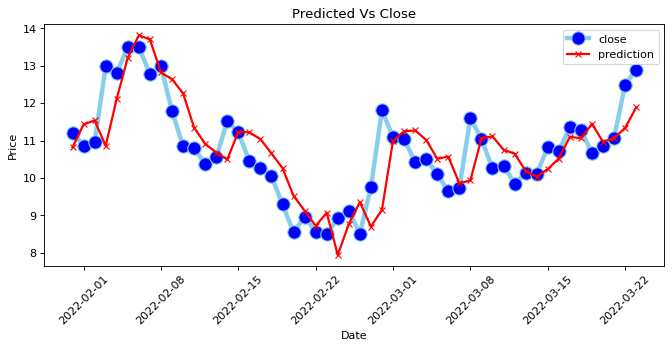

In [26]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)
 
# Data
# df = testerdf.tail(33)
results = results.reset_index()
# multiple line plots
plt.plot( 'date', 'close', data=results, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'date', 'prediction', data=results, marker='x', color='red', linewidth=2)

# show legend
plt.legend()
# change the figure size
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted Vs Close")
# plot a line chart

# show graph
plt.show()

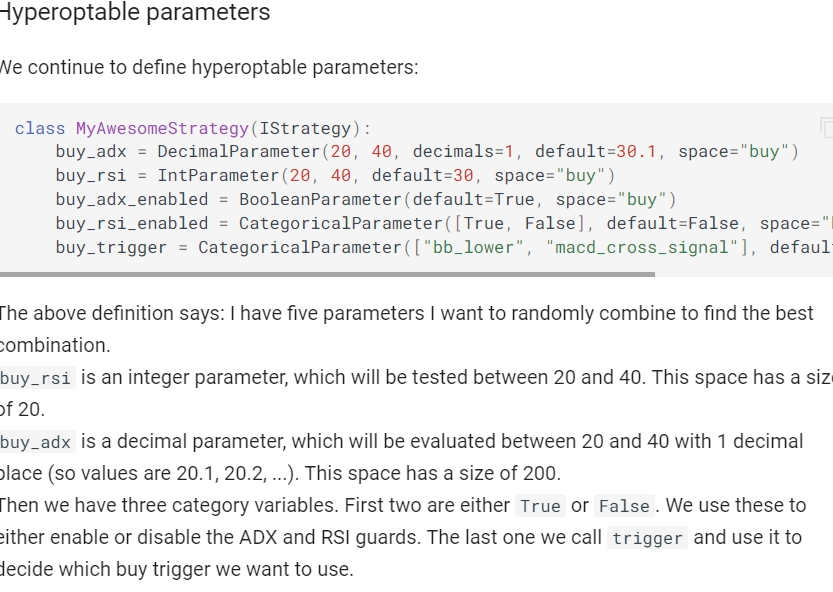

In [28]:
from IPython.display import Image
Image("image.jpg")

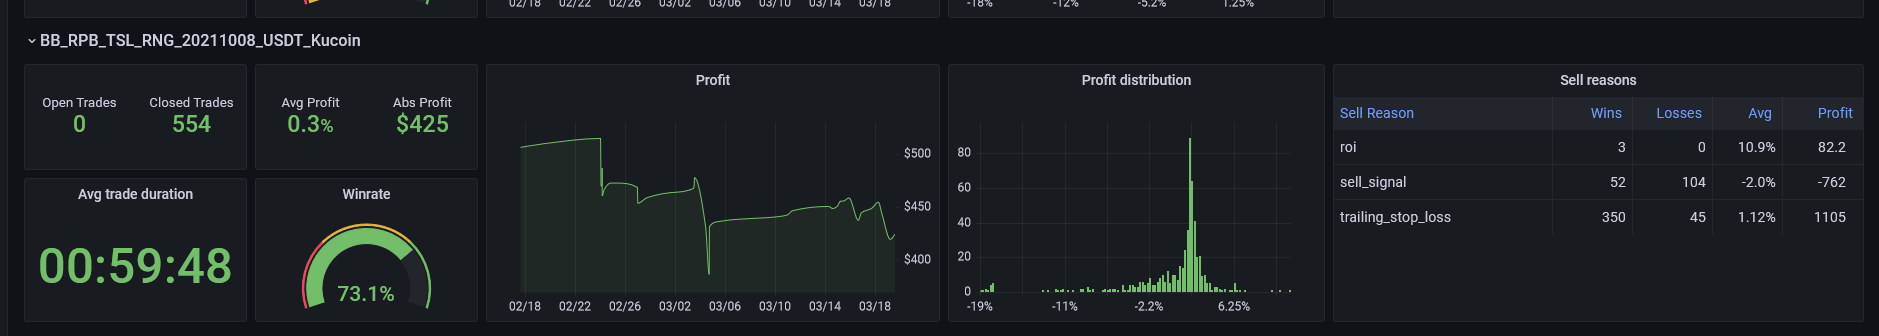

In [29]:
from IPython.display import Image
Image("image.png")